ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏãúÏûë (very_delay Í∞ÄÏ§ëÏπò: 15)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2907
[LightGBM] [Info] Number of data points in the train set: 8024, number of used features: 74
[LightGBM] [Info] Start training from score -1.279544
[LightGBM] [Info] Start training from score -1.109894
[LightGBM] [Info] Start training from score -0.935876
ÌïôÏäµ ÏôÑÎ£å.


=== ÏµúÏ¢Ö Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÏûÑÍ≥ÑÍ∞í: 0.3) ===
                 precision    recall  f1-score   support

 not_delay(<15)       0.85      0.56      0.68       880
   delay(15-60)       0.70      0.88      0.78      1043
very_delay(‚â•60)       0.54      0.73      0.62        83

       accuracy                           0.74      2006
      macro avg       0.70      0.73      0.69      2006
   weighted avg

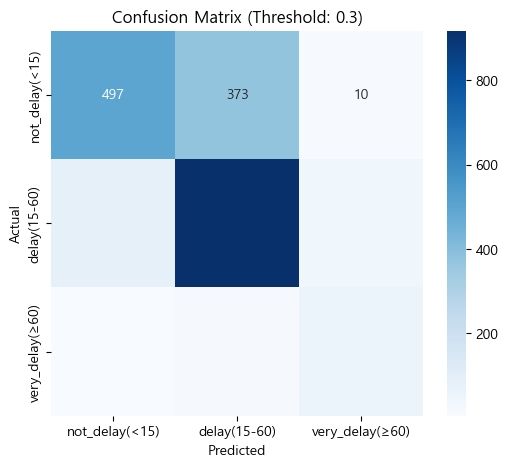

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import platform

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. Ìè∞Ìä∏ ÏÑ§Ï†ï
# ----------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # Mac OS
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------
# 2. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
# ----------------------------
FILE_PATH = "FINAL_ÏµúÏ¢ÖÎ≥ÄÏàò_Ï∂îÍ∞Ä.csv"
df = pd.read_csv(FILE_PATH, encoding='utf-8')

# ÎÇ†Ïßú Î≥ÄÏàò Ï∂îÍ∞Ä
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
df['day_of_week'] = df['Date'].dt.dayofweek
kr_holidays = holidays.KR()
df['is_holiday'] = df['Date'].apply(lambda x: x in kr_holidays).astype(int)
df = df.drop(columns=['Date'])

# Target/Feature Ï†ïÏùò
# delay_min ‚Üí Íµ¨Í∞ÑÌôîÌï¥ÏÑú ÌÅ¥ÎûòÏä§ Î†àÏù¥Î∏î ÏÉùÏÑ±
bins = [float("-inf"), 15, 60, float("inf")]
labels = [0, 1, 2]  # 0=ÎπÑÏßÄÏó∞, 1=ÏßÄÏó∞, 2=Îß§Ïö∞ÏßÄÏó∞
df['target'] = pd.cut(df['delay_min'], bins=bins, labels=labels, right=False).astype(int)

y = df['target'].values
X = df.drop(columns=['delay_min', 'STD', 'target'])

# Ïà´Ïûê/Î≤îÏ£ºÌòï Î∂ÑÎ¶¨
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# OHE Ìï®Ïàò (Î≤ÑÏ†Ñ Ìò∏ÌôòÏÑ±)
def make_ohe():
    try:
        return OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        return OneHotEncoder(sparse=False, handle_unknown="ignore")

# Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("anova", SelectKBest(score_func=f_classif, k=30))
])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])
preprocess = ColumnTransformer(
    [("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)],
    remainder="drop"
)

# ----------------------------
# 3. ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
# ----------------------------
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# ----------------------------
# 4. Î™®Îç∏ ÌïôÏäµ (Í∞ÄÏ§ëÏπò Ï†ÅÏö©)
# ----------------------------
best_weight = 15
print(f"ÏµúÏ¢Ö Î™®Îç∏ ÌïôÏäµ ÏãúÏûë (very_delay Í∞ÄÏ§ëÏπò: {best_weight})")

# ÌÅ¥ÎûòÏä§Î≥Ñ Í∞ÄÏ§ëÏπò (Ïó¨Í∏∞ÏÑúÎäî Îß§Ïö∞ÏßÄÏó∞=2Ïóê 15Î∞∞ Í∞ÄÏ§ëÏπò)
sample_weights = np.array([best_weight if yi == 2 else 1 for yi in y_tr])

final_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(
        objective="multiclass",
        num_class=3,
        random_state=42,
        n_jobs=-1
    ))
])
final_model.fit(X_tr, y_tr, clf__sample_weight=sample_weights)
print("ÌïôÏäµ ÏôÑÎ£å.")

# ----------------------------
# 5. ÏòàÏ∏° ÌôïÎ•†ÏùÑ Ïù¥Ïö©Ìïú ÏûÑÍ≥ÑÍ∞í Ï°∞Ï†ï Î∞è ÌèâÍ∞Ä
# ----------------------------
# 1. Í∞Å ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÏòàÏ∏° ÌôïÎ•† ÏñªÍ∏∞
y_prob = final_model.predict_proba(X_va)

# 2. ÏÉàÎ°úÏö¥ ÏûÑÍ≥ÑÍ∞í ÏÑ§Ï†ï (Ïù¥ Í∞íÏùÑ 0.2 ~ 0.4 ÏÇ¨Ïù¥ÏóêÏÑú Ï°∞Ï†àÌï¥Î≥¥ÏÑ∏Ïöî)
custom_threshold = 0.3

# 3. ÏûÑÍ≥ÑÍ∞í Ï†ÅÏö©ÌïòÏó¨ ÏµúÏ¢Ö ÏòàÏ∏° ÏÉùÏÑ±
# ÏùºÎã® Í∞ÄÏû• ÌôïÎ•†Ïù¥ ÎÜíÏùÄ ÌÅ¥ÎûòÏä§Î°ú ÏòàÏ∏°
y_pred_tuned = np.argmax(y_prob, axis=1)
# 'Îß§Ïö∞ ÏßÄÏó∞'(class 2)Ïùò ÌôïÎ•†Ïù¥ Ïö∞Î¶¨Í∞Ä Ï†ïÌïú ÏûÑÍ≥ÑÍ∞íÏùÑ ÎÑòÏúºÎ©¥, ÏòàÏ∏°ÏùÑ Í∞ïÏ†úÎ°ú 2Î°ú Î≥ÄÍ≤Ω
y_pred_tuned[y_prob[:, 2] > custom_threshold] = 2

# 4. Ï°∞Ï†ïÎêú ÏòàÏ∏° Í≤∞Í≥ºÎ°ú ÏÑ±Îä• ÌèâÍ∞Ä
print(f"\n\n=== ÏµúÏ¢Ö Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä (ÏûÑÍ≥ÑÍ∞í: {custom_threshold}) ===")
target_names = ["not_delay(<15)", "delay(15-60)", "very_delay(‚â•60)"]
print(classification_report(y_va, y_pred_tuned, target_names=target_names, zero_division=0))

# ÌòºÎèôÌñâÎ†¨ ÏãúÍ∞ÅÌôî
cm = confusion_matrix(y_va, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold: {custom_threshold})")
plt.show()


SelectKBestÏóê ÏùòÌï¥ ÏÑ†ÌÉùÎêú Ïà´ÏûêÌòï ÌîºÏ≤ò Í∞úÏàò: 30

Î™®Îç∏Ïóê Í∞ÄÏû• ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò:
                         Feature  Importance
27        prev_flights_avg_delay         916
1                         Í∏∞Ïò®(¬∞C)         762
26        route_congestion_index         739
7                      Ïù¥Ïä¨Ï†êÏò®ÎèÑ(¬∞C)         572
9                 ÌíçÏÜç*sin(ÌíçÌñ•-ÌôúÏ£ºÎ°ú)         549
15                          hour         489
17                      Ïö¥Ìñâ ÏúÑÌóò ÏßÄÏàò         418
28             congestion_x_wind         416
29  congestion_x_visibility_risk         413
25         flights_per_day_route         396
2                    10Î∂ÑÌèâÍ∑†ÌíçÏÜç(KT)         368
3                   10Î∂ÑÌèâÍ∑†ÌíçÌñ•(deg)         288
16                          ÌÖåÏùºÏúàÎìú         271
0                           year         262
22                     ÌíçÌñ•-ÌôúÏ£ºÎ°ú_Ìé∏Ï∞®         198
23              congestion_index         196
19                      ÎÇ†Ï

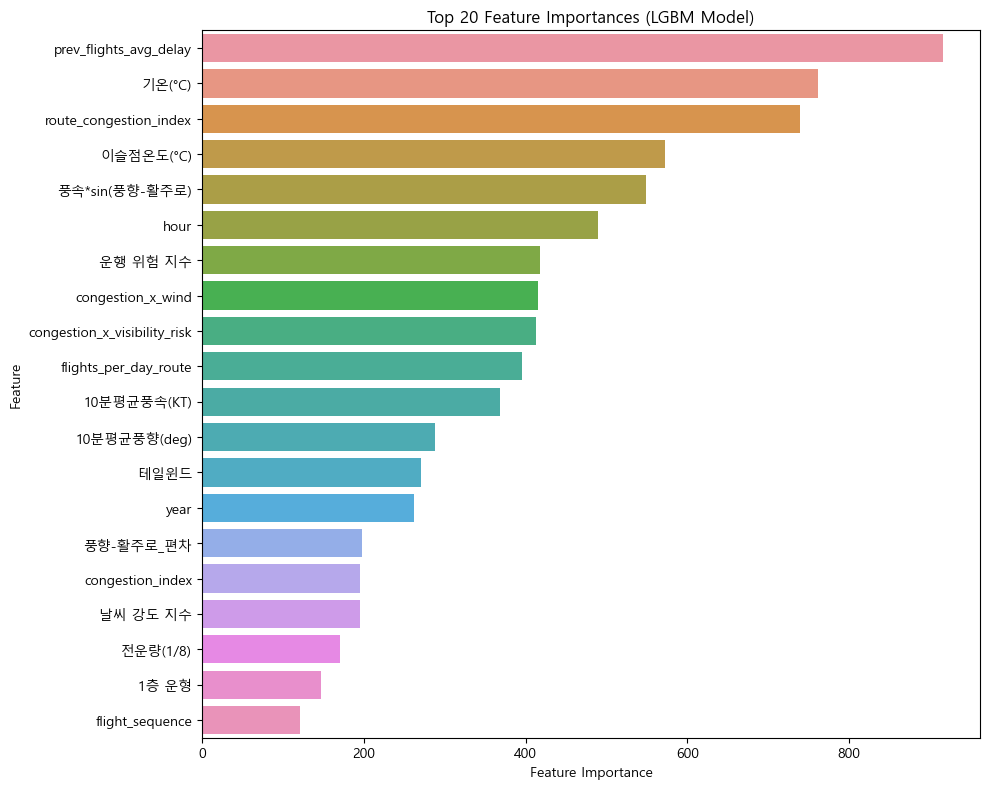


ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÏùò Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôîÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.


In [2]:
import shap  # SHAP ÎùºÏù¥Î∏åÎü¨Î¶¨ (Ï†ïÌôïÌïú ÌîºÏ≤ò Ïù¥Î¶Ñ Ï∂îÏ∂úÏùÑ ÏúÑÌï¥ Í≥ÑÏÜç ÏÇ¨Ïö©)
import matplotlib.pyplot as plt

# ----------------------------
# 1. ÌîºÏ≤ò Ïù¥Î¶Ñ Ï∂îÏ∂ú (Î™®Îç∏ ÌïôÏäµ ÌõÑÏóê Ïã§Ìñâ)
# ----------------------------

# Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏ÏóêÏÑú Í∞Å Î≥ÄÌôòÍ∏∞ Ï∂îÏ∂ú
preprocessor = final_model.named_steps['preprocess']

# 1. Ïà´ÏûêÌòï ÌîºÏ≤ò Ïù¥Î¶Ñ (SelectKBestÏùò Í≤∞Í≥ºÎ•º Ìè¨Ìï®ÌïòÏßÄ ÏïäÎäî 'ÏõêÎûò' Ïà´ÏûêÌòï Ïª¨Îüº Ïù¥Î¶Ñ)
# NOTE: ÌòÑÏû¨ ÌååÏù¥ÌîÑÎùºÏù∏ÏùÄ ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú SelectKBestÎ•º ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú Î™®Îì† Num_colsÎ•º Ï≤òÎ¶¨Ìï©ÎãàÎã§.
# ÌïòÏßÄÎßå SelectKBestÍ∞Ä Ìè¨Ìï®Îêú Num_tfÍ∞Ä Ï†ÑÏ≤¥ ÌååÏù¥ÌîÑÎùºÏù∏Ïóê Îì§Ïñ¥Í∞Ä ÏûàÏúºÎØÄÎ°ú,
# Ïã§Ï†ú ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú ÌîºÏ≤ò Í∞úÏàòÎ•º Ï†ïÌôïÌûà ÏïåÏïÑÏïº Ìï©ÎãàÎã§.

# SelectKBestÍ∞Ä Ìè¨Ìï®Îêú num_tfÎ•º ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î°ú fitÌïòÏó¨ ÏÑ†ÌÉùÎêú ÌîºÏ≤òÎ•º ÌôïÏù∏Ìï©ÎãàÎã§.
# (ÏõêÎûò ÏΩîÎìúÏóêÏÑú Ïù¥ Î∂ÄÎ∂ÑÏù¥ ÎàÑÎùΩÎêòÏóàÏúºÎØÄÎ°ú, Ïó¨Í∏∞ÏÑú fitÏùÑ ÏàòÌñâÌï©ÎãàÎã§. 
# ÌïòÏßÄÎßå Ïù¥ÎØ∏ final_model.fitÏóêÏÑú ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú fitÏù¥ ÏôÑÎ£åÎêòÏóàÏùÑ Ïàò ÏûàÏúºÎØÄÎ°ú, 
# ColumnTransformer ÎÇ¥Î∂ÄÏùò SelectKBest ÏÉÅÌÉúÎ•º ÌôïÏù∏Ìï©ÎãàÎã§.)

num_transformer = preprocessor.named_transformers_['num']
# num_transformerÎäî SimpleImputer, StandardScaler, SelectKBestÎ•º Ìè¨Ìï®ÌïòÎäî PipelineÏûÖÎãàÎã§.
anova_step = num_transformer.named_steps['anova']

# anova_stepÏù¥ fitÎêòÏóàÎäîÏßÄ ÌôïÏù∏ÌïòÍ≥†, ÏÑ†ÌÉùÎêú Ïù∏Îç±Ïä§ Í∞ÄÏ†∏Ïò§Í∏∞
selected_num_indices = anova_step.get_support(indices=True)
selected_num_cols = [num_cols[i] for i in selected_num_indices]
print(f"SelectKBestÏóê ÏùòÌï¥ ÏÑ†ÌÉùÎêú Ïà´ÏûêÌòï ÌîºÏ≤ò Í∞úÏàò: {len(selected_num_cols)}")


# 2. Î≤îÏ£ºÌòï OHE ÌîºÏ≤ò Ïù¥Î¶Ñ Ï∂îÏ∂ú
cat_transformer = preprocessor.named_transformers_['cat']
ohe_step = cat_transformer.named_steps['ohe']
# OHEÍ∞Ä ÌïôÏäµÎêú Î≤îÏ£º Î™©Î°ùÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÌîºÏ≤ò Ïù¥Î¶ÑÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
ohe_feature_names = ohe_step.get_feature_names_out(cat_cols)

# ÏµúÏ¢Ö ÌîºÏ≤ò Ïù¥Î¶Ñ Î™©Î°ù: ColumnTransformerÏùò ÏàúÏÑúÏóê Îî∞Îùº Ìï©Ïπ©ÎãàÎã§.
# Ï£ºÏùò: num_tfÍ∞Ä SelectKBestÎ•º Ìè¨Ìï®ÌïòÎØÄÎ°ú, 'ÏÑ†ÌÉùÎêú' Ïà´Ïûê ÌîºÏ≤ò Ïù¥Î¶ÑÎßå ÏÇ¨Ïö©Ìï©ÎãàÎã§.
all_feature_names = selected_num_cols + list(ohe_feature_names)
N_FEATURES_USED = len(all_feature_names)


# ----------------------------
# 2. ÌîºÏ≤ò Ï§ëÏöîÎèÑ Í≥ÑÏÇ∞ Î∞è Ï†ïÎ†¨
# ----------------------------
classifier = final_model.named_steps['clf']
feature_importances = classifier.feature_importances_

if len(feature_importances) != N_FEATURES_USED:
    print("\nüö® Í≤ΩÍ≥†: LGBM Ï§ëÏöîÎèÑ Î∞∞Ïó¥ ÌÅ¨Í∏∞Í∞Ä ÏµúÏ¢Ö ÌîºÏ≤ò Ïù¥Î¶Ñ Î™©Î°ù ÌÅ¨Í∏∞ÏôÄ Îã§Î¶ÖÎãàÎã§!")
    print(f"LGBM Ï§ëÏöîÎèÑ ÌÅ¨Í∏∞: {len(feature_importances)}, ÏòàÏÉÅ ÌÅ¨Í∏∞: {N_FEATURES_USED}")
    # Ïù¥ Í≤ΩÏö∞, SelectKBestÍ∞Ä ÌååÏù¥ÌîÑÎùºÏù∏ ÎÇ¥Î∂ÄÏóêÏÑú ÏòàÏÉÅÍ≥º Îã§Î•¥Í≤å ÎèôÏûëÌñàÍ±∞ÎÇò,
    # OHE Í≥ºÏ†ïÏóêÏÑú Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌñàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏäµÎãàÎã§.
    # ÏïàÏ†ÑÏùÑ ÏúÑÌï¥ ÏòàÏÉÅ ÌÅ¨Í∏∞ÎßåÌÅºÎßå ÏÇ¨Ïö©ÌïòÍ±∞ÎÇò, ÏΩîÎìúÎ•º Ï§ëÎã®Ìï¥Ïïº Ìï©ÎãàÎã§.
    # Ïó¨Í∏∞ÏÑúÎäî Ï†ÅÏ†àÌïú Í∏∏Ïù¥ÎßåÌÅº ÏûêÎ¶ÖÎãàÎã§.
    feature_importances = feature_importances[:N_FEATURES_USED]
    

# ÌîºÏ≤ò Ïù¥Î¶ÑÍ≥º Ï§ëÏöîÎèÑÎ•º DataFrameÏúºÎ°ú Í≤∞Ìï©
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Ï§ëÏöîÎèÑ ÏàúÏúºÎ°ú ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò ÏÑ†ÌÉù
top_20_features = importance_df.head(20)

print(f"\nÎ™®Îç∏Ïóê Í∞ÄÏû• ÌÅ∞ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò:")
print(top_20_features)


# ----------------------------
# 3. ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò ÏãúÍ∞ÅÌôî
# ----------------------------
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances (LGBM Model)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤òÏùò Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôîÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.")


=== SHAP Î∂ÑÏÑù ÏãúÏûë ===

Shape of shap_values_raw: (1000, 148, 3)
Shape of sample_data: (1000, 148)

=== SHAP for class 0: not_delay(<15) ===


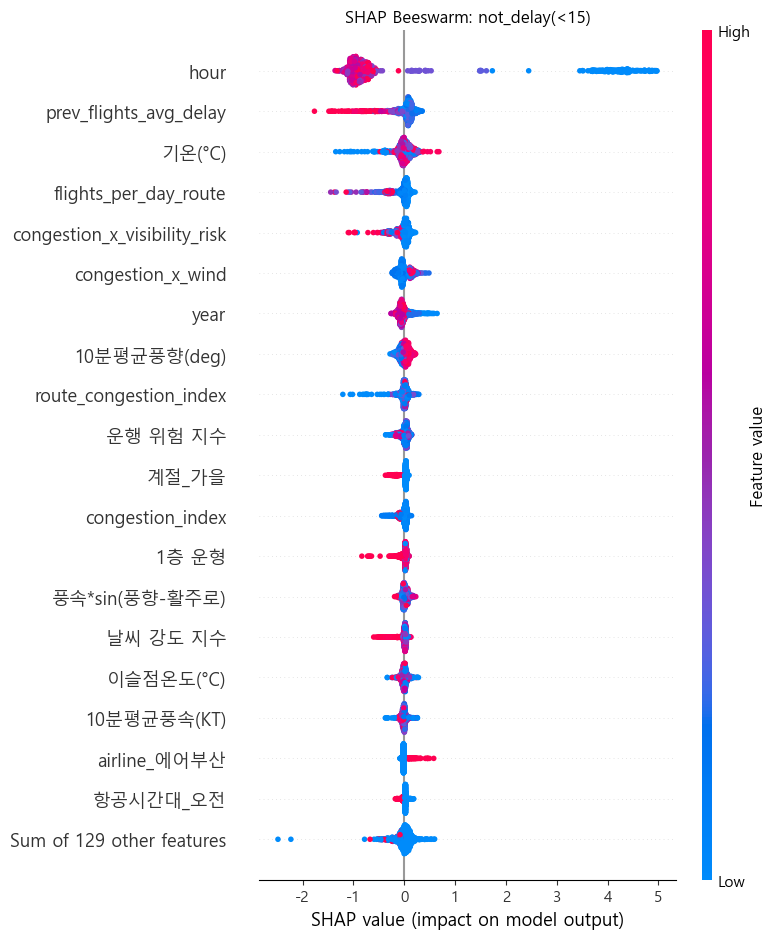

not_delay(<15)Ïóê ÎåÄÌïú ÌîåÎ°Ø ÏÉùÏÑ±Ïù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.

=== SHAP for class 1: delay(15-60) ===


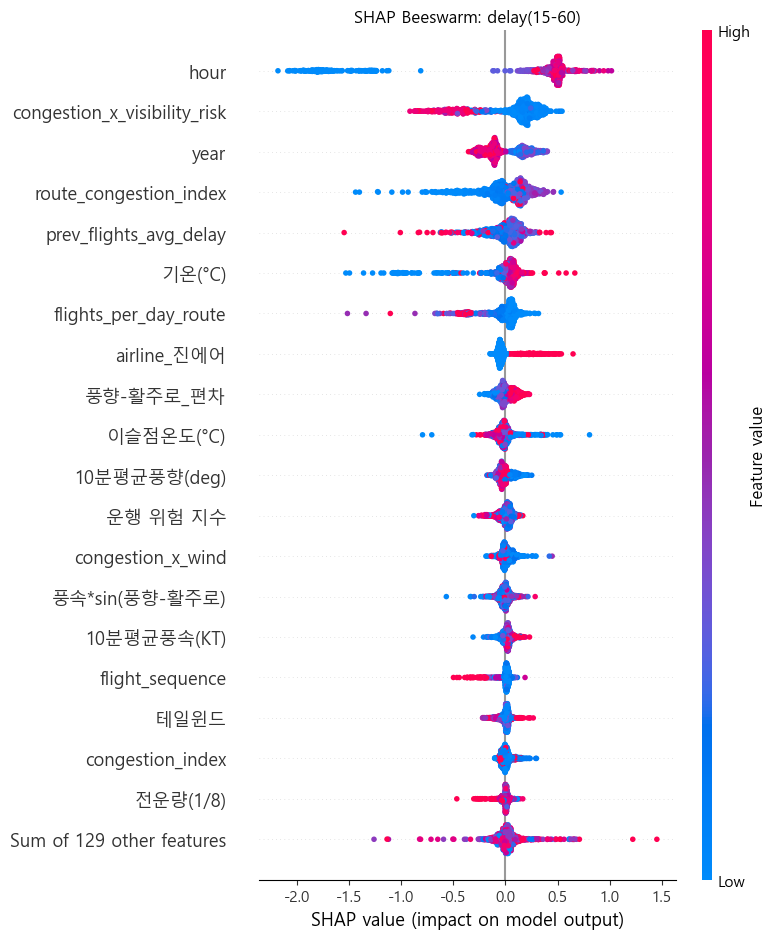

delay(15-60)Ïóê ÎåÄÌïú ÌîåÎ°Ø ÏÉùÏÑ±Ïù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.

=== SHAP for class 2: very_delay(‚â•60) ===


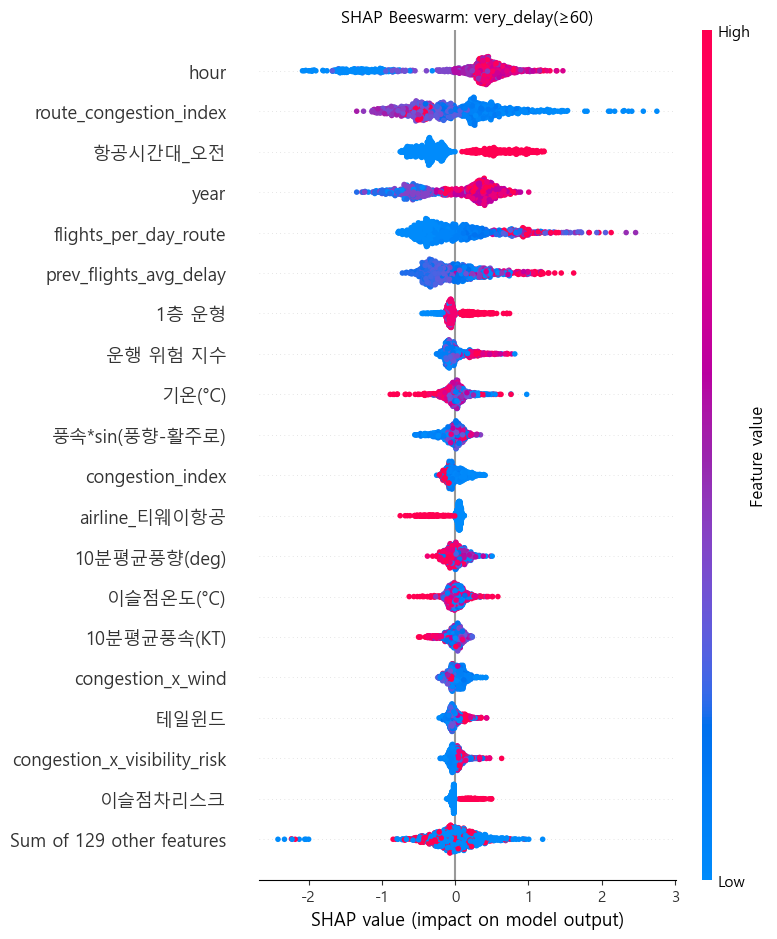

very_delay(‚â•60)Ïóê ÎåÄÌïú ÌîåÎ°Ø ÏÉùÏÑ±Ïù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.


In [3]:
# ----------------------------
# 5. SHAP Î∂ÑÏÑù (Î¨∏Ï†úÍ∞Ä Ìï¥Í≤∞Îêú ÏµúÏ¢Ö Î≤ÑÏ†Ñ)
# ----------------------------
print("\n=== SHAP Î∂ÑÏÑù ÏãúÏûë ===")

# SHAP Explainer Í∞ùÏ≤¥ ÏÉùÏÑ±
model = final_model.named_steps['clf']
explainer = shap.TreeExplainer(model)

# Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ
preprocessor = final_model.named_steps['preprocess']
num_features_after_anova = preprocessor.named_transformers_['num'].named_steps['anova'].get_feature_names_out(num_cols)
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols)
feature_names = list(num_features_after_anova) + list(ohe_feature_names)

X_va_transformed = preprocessor.transform(X_va)
X_va_transformed_df = pd.DataFrame(X_va_transformed, columns=feature_names)

# SHAP Í∞í Í≥ÑÏÇ∞ (ÏÉòÌîå ÏàòÎ•º 500ÏúºÎ°ú Ï§ÑÏó¨ Î©îÎ™®Î¶¨ Î¨∏Ï†ú ÏôÑÌôî)
sample_data = X_va_transformed_df.sample(n=1000, random_state=42)
shap_values_raw = explainer.shap_values(sample_data)

# SHAP Í∞íÍ≥º Îç∞Ïù¥ÌÑ∞Ïùò shape Î∞è ÌÉÄÏûÖÏùÑ ÌôïÏù∏ (ÎîîÎ≤ÑÍπÖ Î™©Ï†Å)
print(f"\nShape of shap_values_raw: {np.array(shap_values_raw).shape}")
print(f"Shape of sample_data: {sample_data.shape}")

# shap_valuesÏùò Ï∞®ÏõêÏùÑ (classes, samples, features)Î°ú Ïû¨Íµ¨ÏÑ±Ìï©ÎãàÎã§.
if isinstance(shap_values_raw, list):
    shap_values_corrected = np.array(shap_values_raw)
else:
    # SHAPÏù¥ (ÏÉòÌîå, ÌîºÏ≤ò, ÌÅ¥ÎûòÏä§) ÌòïÌÉúÎ°ú Î∞òÌôòÌïòÎäî Í≤ΩÏö∞
    shap_values_corrected = np.transpose(shap_values_raw, (2, 0, 1))

# Î™®Îì† ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú SHAP ÌîåÎ°Ø ÏÉùÏÑ±
target_names = ["not_delay(<15)", "delay(15-60)", "very_delay(‚â•60)"]
for i, class_name in enumerate(target_names):
    print(f"\n=== SHAP for class {i}: {class_name} ===")

    # --- Beeswarm Plot ---
    plt.figure()
    expl = shap.Explanation(
        values=shap_values_corrected[i],
        data=sample_data,
        feature_names=feature_names
    )
    shap.plots.beeswarm(expl, max_display=20, show=False)
    plt.title(f"SHAP Beeswarm: {class_name}")
    plt.tight_layout()
    # ÌîåÎ°ØÏùÑ Ïù¥ÎØ∏ÏßÄ ÌååÏùºÎ°ú Ï†ÄÏû•
    plt.savefig(f"shap_beeswarm_{i}_{class_name.replace('<', '').replace('>', '').replace('=', '').replace(' ', '_')}.png")
    plt.show()

    # Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
    plt.close('all')
    print(f"{class_name}Ïóê ÎåÄÌïú ÌîåÎ°Ø ÏÉùÏÑ±Ïù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§.")